# Running an adaptive speciaton model in a static landscape

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from adascape.base import IR12SpeciationModel
from adascape.fastscape_ext import FastscapeElevationTrait

%matplotlib inline

# Build a static landscape

In [2]:
length = (250, 250)
spacing = (1, 1)

x, y = np.meshgrid(*[np.arange(0, l+s, s)
                     for l, s in zip(length, spacing)])

r = np.random.RandomState(0)

environment = x * 10 + r.rand(*y.shape)

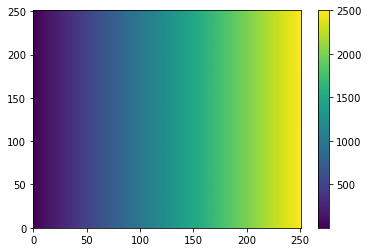

In [3]:
plt.pcolormesh(environment)
plt.colorbar()

# Initialize traits and environmental fields for speciation models

In [4]:
# initialize two traits associated with elevation
# where the initial min/max provides the range of 
# trait values that the individual will have and
# slope determines the linear relationship between
# environmental field and the optimal trait value
# for each individual on that field.
trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
trait_01_elev.initialize()

trait_02_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=-0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
trait_02_elev.initialize()

# dict of callables to generate initial values for each trait
init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func,
    'trait_2': trait_02_elev.init_trait_func
}

# dict of callables to compute optimal values for each trait
opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func,
    'trait_2': trait_02_elev.opt_trait_func
}

## Speciation model without trait-mediated competition

In [5]:
def model1_run(x=x, y=y, init_trait_funcs=init_trait_funcs, 
               opt_trait_funcs=opt_trait_funcs, 
               init_abundance=10, nb_radius=50, car_cap=30,
               sigma_env_trait=0.2, sigma_mov=5, sigma_mut=0.05,
               mut_prob=0.5, random_seed=1234, dt=1e0, num_gen=500,
              taxon_threshold=0.05):
    
    
    # define a speciation model using the specified parameter values
    model1 = IR12SpeciationModel(grid_x=x, grid_y=y, init_trait_funcs=init_trait_funcs, 
                                 opt_trait_funcs=opt_trait_funcs, init_abundance=init_abundance, 
                                 nb_radius=nb_radius, car_cap=car_cap,
                                 sigma_env_trait=sigma_env_trait, 
                                 sigma_mov=sigma_mov, sigma_mut=sigma_mut,
                                 mut_prob=mut_prob, random_seed=random_seed,
                                 taxon_threshold=taxon_threshold)
    print(model1)
    # initialize the speciation model
    model1.initialize()
    # run the speciation model for the number of generations
    dfs1 = []
    for step in range(num_gen):
        model1.evaluate_fitness(dt)
        dfs1.append(model1.to_dataframe())
        model1.update_individuals(dt)
    return pd.concat(dfs1)

In [6]:
%time df1 = model1_run()
df1

<IR12SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    distance_metric: ward
    taxon_threshold: 0.05
    taxon_def: spec_clus
    nb_radius: 50
    car_cap: 30
    sigma_env_trait: 0.2
    sigma_mov: 5
    sigma_mut: 0.05
    mut_prob: 0.5



/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


CPU times: user 25.4 s, sys: 2.14 s, total: 27.5 s
Wall time: 7.38 s


,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0,trait_1
0,0,0.0,0.0,244.174942,110.251531,1.0,0.0,0,0.006031,0.500000,0.500000
1,0,0.0,0.0,95.048934,152.467702,1.0,0.0,7,0.723356,0.500000,0.500000
2,0,0.0,0.0,230.811558,215.905324,1.0,0.0,1,0.017309,0.500000,0.500000
3,0,0.0,0.0,65.423106,215.939418,1.0,0.0,2,0.272955,0.500000,0.500000
4,0,0.0,0.0,79.774265,168.720328,1.0,0.0,4,0.482343,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
258,499,499.0,0.0,55.798667,222.323073,26741.0,26682.0,1,0.615599,0.255689,0.565747
259,499,499.0,0.0,37.366572,241.131997,26742.0,26683.0,1,0.776651,0.204686,0.697409
260,499,499.0,0.0,111.840406,190.620720,26741.0,26682.0,1,0.735723,0.304503,0.606580
261,499,499.0,0.0,126.720829,224.816022,26742.0,26683.0,1,0.800036,0.374216,0.488679


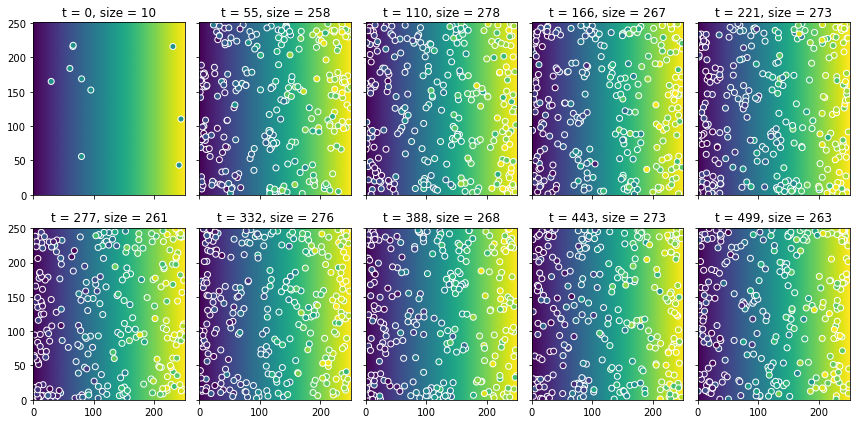

In [7]:
fig1, axes1 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes1.ravel(), np.linspace(0,df1.step.unique().size-1,10).astype(int)):
    pop = df1.groupby('step').get_group(print_step)
    ax.pcolormesh(environment)
    ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig1.tight_layout()

Text(0.5, 0, 'Time (generations)')

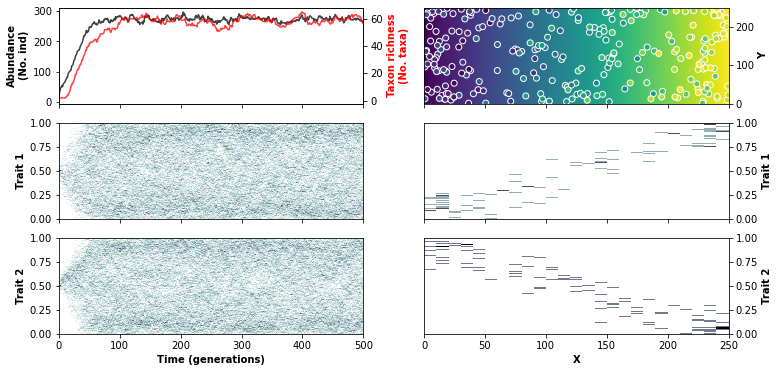

In [8]:
fig2, axs2 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
axs2[0,0].plot(df1.groupby('step').size(), c='black', alpha=0.75)
axs2_2 = axs2[0,0].twinx()
axs2_2.plot(df1.groupby(['step']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)

axs2[0, 1].pcolormesh(environment)
axs2[0, 1].scatter(df1['x'].loc[df1['step']==max(df1['step'])], 
                   df1['y'].loc[df1['step']==max(df1['step'])], 
                   c=df1['trait_0'].loc[df1['step']==max(df1['step'])],
                   edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs2[1,1].hist2d(x=df1['x'].loc[df1['step']==max(df1['step'])], 
                                 y=df1['trait_0'].loc[df1['step']==max(df1['step'])], 
                                 range=((0, x.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs2[1,0].hist2d(x=df1['step'], y=df1['trait_0'], 
                                 range=((0, df1.step.unique().size), (0, 1)), 
                                 bins=(df1.step.unique().size, 100), cmap='bone_r')
h,xedge,yedge,_=axs2[2,1].hist2d(x=df1['x'].loc[df1['step']==max(df1['step'])], 
                                 y=df1['trait_1'].loc[df1['step']==max(df1['step'])], 
                                 range=((0, x.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs2[2,0].hist2d(x=df1['step'], y=df1['trait_1'], 
                                 range=((0, df1.step.unique().size), (0, 1)), 
                                 bins=(df1.step.unique().size, 100), cmap='bone_r')
axs2[0, 1].yaxis.set_label_position("right")
axs2[0, 1].yaxis.tick_right()
axs2[1, 1].yaxis.set_label_position("right")
axs2[1, 1].yaxis.tick_right()
axs2[2, 1].yaxis.set_label_position("right")
axs2[2, 1].yaxis.tick_right()
axs2[0, 1].set_ylabel('Y', weight='bold')
axs2[0, 0].set_ylabel('Abundance\n(No. ind)', weight='bold')
axs2_2.set_ylabel('Taxon richness\n(No. taxa)', weight='bold', color='red')
axs2[1, 1].set_ylabel('Trait 1', weight='bold')
axs2[1, 0].set_ylabel('Trait 1', weight='bold')
axs2[2, 1].set_ylabel('Trait 2', weight='bold')
axs2[2, 0].set_ylabel('Trait 2', weight='bold')
axs2[2, 1].set_xlabel('X', weight='bold')
axs2[2, 0].set_xlabel('Time (generations)', weight='bold')

## Speciation model with trait-mediated competition

In [9]:
from adascape.base import DD03SpeciationModel

In [10]:
def model2_run(x=x, y=x, init_trait_funcs=init_trait_funcs, 
               opt_trait_funcs=opt_trait_funcs, init_abundance=10,
               car_cap_max=250, sigma_env_trait=0.2, 
               mut_prob=0.5, sigma_mut=0.05, sigma_mov=5, 
               sigma_comp_trait=0.9, sigma_comp_dist=0.1, 
               random_seed=1234, taxon_threshold=0.05,
               dt=1e0, num_gen=500,):
    
    # define a speciation model using the specified parameter values
    model2 = DD03SpeciationModel(grid_x=x, grid_y=y, init_trait_funcs=init_trait_funcs, 
                                 opt_trait_funcs=opt_trait_funcs, init_abundance=init_abundance,
                                 car_cap_max=car_cap_max, sigma_env_trait=sigma_env_trait, 
                                 mut_prob=mut_prob, sigma_mut=sigma_mut, sigma_mov=sigma_mov, 
                                 sigma_comp_trait=sigma_comp_trait, sigma_comp_dist=sigma_comp_dist, 
                                 random_seed=random_seed, taxon_threshold=taxon_threshold)
    
    print(model2)
    # initialize the speciation model
    model2.initialize()
    dfs2 = []
    # run the speciation model for the number of generations
    for step in range(num_gen):
        model2.evaluate_fitness(dt)
        dfs2.append(model2.to_dataframe())
        model2.update_individuals(dt)
    return pd.concat(dfs2)

In [11]:
%time df2 = model2_run()
df2

<DD03SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    distance_metric: ward
    taxon_threshold: 0.05
    taxon_def: spec_clus
    birth_rate: 1
    movement_rate: 5
    car_cap_max: 250
    sigma_env_trait: 0.2
    mut_prob: 0.5
    sigma_mut: 0.05
    sigma_mov: 5
    sigma_comp_trait: 0.9
    sigma_comp_dist: 0.1



/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


CPU times: user 1min 56s, sys: 20.7 s, total: 2min 17s
Wall time: 38.1 s


,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,events_i,death_i,trait_0,trait_1
0,0,0.0,0.0,244.174942,110.251531,1.0,0.0,2,B,0.050904,0.500000,0.500000
1,0,0.0,0.0,95.048934,152.467702,1.0,0.0,1,M,0.047647,0.500000,0.500000
2,0,0.0,0.0,230.811558,215.905324,1.0,0.0,1,M,0.167722,0.500000,0.500000
3,0,0.0,0.0,65.423106,215.939418,1.0,0.0,1,M,0.051565,0.500000,0.500000
4,0,0.0,0.0,79.774265,168.720328,1.0,0.0,2,B,0.050757,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
208,499,499.0,1.0,23.665952,66.010947,17956.0,17920.0,1,M,1.073823,0.117297,0.499709
209,499,499.0,1.0,0.821354,90.247115,17956.0,17920.0,1,M,1.540674,0.241870,0.316188
210,499,499.0,1.0,135.544667,142.560823,17956.0,17920.0,1,M,0.903000,0.497957,0.348858
211,499,499.0,1.0,171.772859,109.884288,17957.0,17921.0,1,M,1.035366,0.631967,0.665885


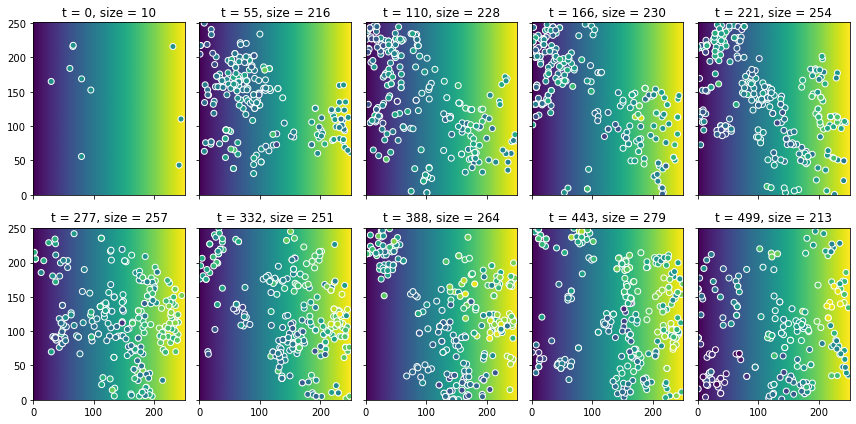

In [12]:
fig3, axes3 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes3.ravel(), np.linspace(0,df1.step.unique().size-1,10).astype(int)):
    pop = df2.groupby('step').get_group(print_step)
    ax.pcolormesh(environment)
    ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig3.tight_layout()

Text(0.5, 0, 'Time (generations)')

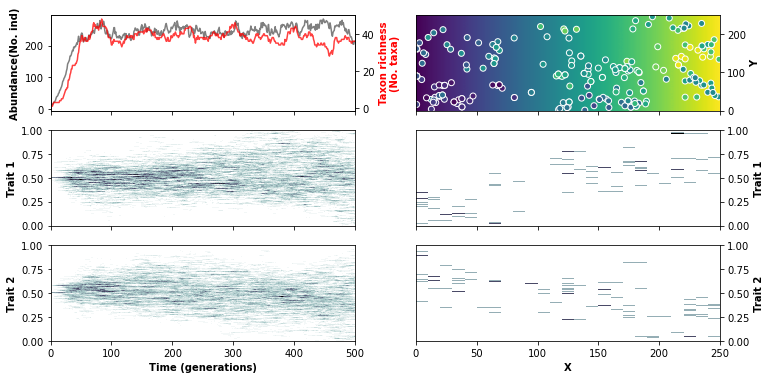

In [13]:
fig4, axs4 = plt.subplots(3, 2, sharex="col", figsize=(12, 6))
axs4[0,0].plot(df2.groupby('step').size(), c='black', alpha=0.5)
axs4_2 = axs4[0,0].twinx()
axs4_2.plot(df2.groupby(['step']).apply(lambda x: x.taxon_id.unique().size), c='red', alpha=0.75)

axs4[0, 1].pcolormesh(environment)
axs4[0, 1].scatter(df2['x'].loc[df2['step']==max(df2['step'])], 
                      df2['y'].loc[df2['step']==max(df2['step'])], 
                      c=df2['trait_0'].loc[df2['step']==max(df2['step'])], 
                      edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs4[1,1].hist2d(x=df2['x'].loc[df2['step']==max(df2['step'])], 
                                 y=df2['trait_0'].loc[df2['step']==max(df2['step'])], 
                                 range=((0, x.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs4[1,0].hist2d(x=df2['step'], y=df2['trait_0'], 
                                 range=((0, df1.step.unique().size), (0, 1)), 
                                 bins=(df1.step.unique().size, 100), cmap='bone_r')
h,xedge,yedge,_=axs4[2,1].hist2d(x=df2['x'].loc[df2['step']==max(df2['step'])], 
                                 y=df2['trait_1'].loc[df2['step']==max(df2['step'])], 
                                 range=((0, x.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
h,xedge,yedge,_=axs4[2,0].hist2d(x=df2['step'], y=df2['trait_1'], 
                                 range=((0, df1.step.unique().size), (0, 1)), 
                                 bins=(df1.step.unique().size, 100), cmap='bone_r')
axs4[0, 1].yaxis.set_label_position("right")
axs4[0, 1].yaxis.tick_right()
axs4[1, 1].yaxis.set_label_position("right")
axs4[1, 1].yaxis.tick_right()
axs4[2, 1].yaxis.set_label_position("right")
axs4[2, 1].yaxis.tick_right()
axs4[0, 1].set_ylabel('Y', weight='bold')
axs4[0, 0].set_ylabel('Abundance(No. ind)', weight='bold')
axs4_2.set_ylabel('Taxon richness\n(No. taxa)', weight='bold', color='red')
axs4[1, 1].set_ylabel('Trait 1', weight='bold')
axs4[1, 0].set_ylabel('Trait 1', weight='bold')
axs4[2, 1].set_ylabel('Trait 2', weight='bold')
axs4[2, 0].set_ylabel('Trait 2', weight='bold')
axs4[2, 1].set_xlabel('X', weight='bold')
axs4[2, 0].set_xlabel('Time (generations)', weight='bold')

In [14]:
#%timeit mode1_run()

In [15]:
#%timeit model2_run()